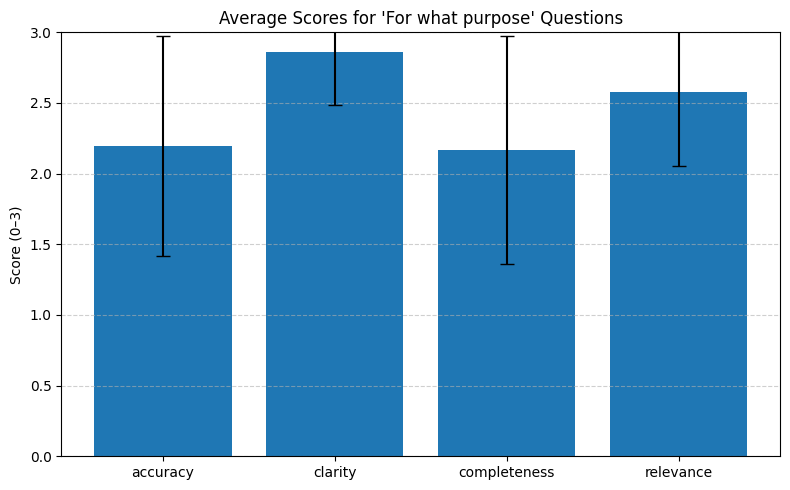

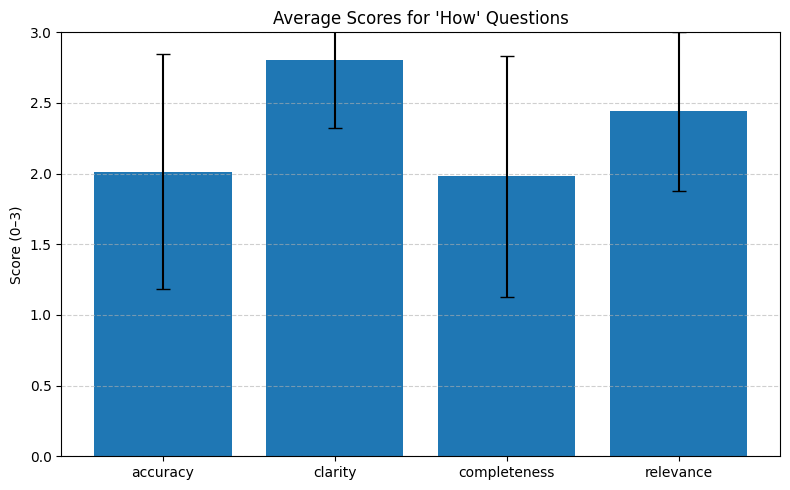

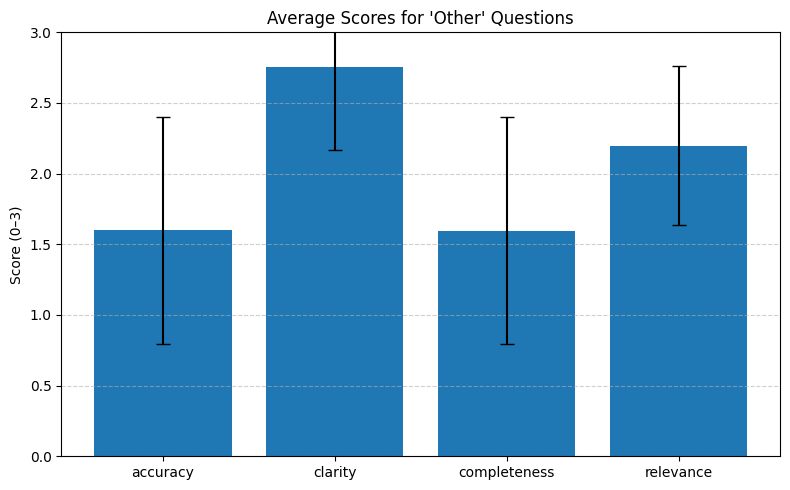

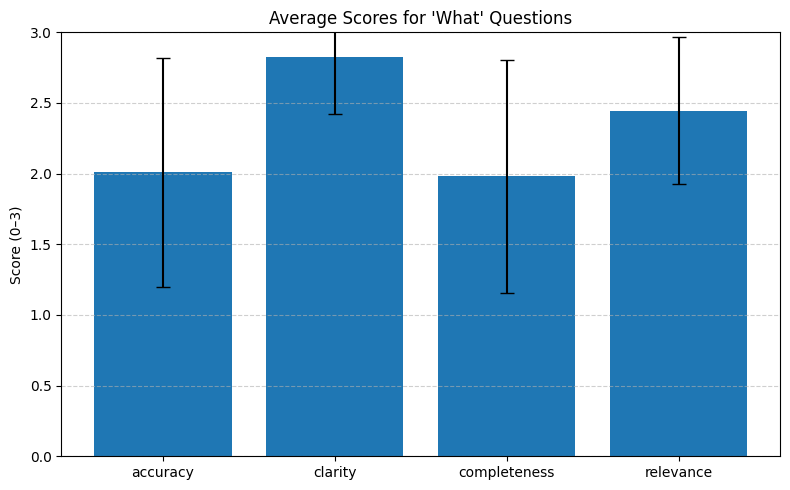

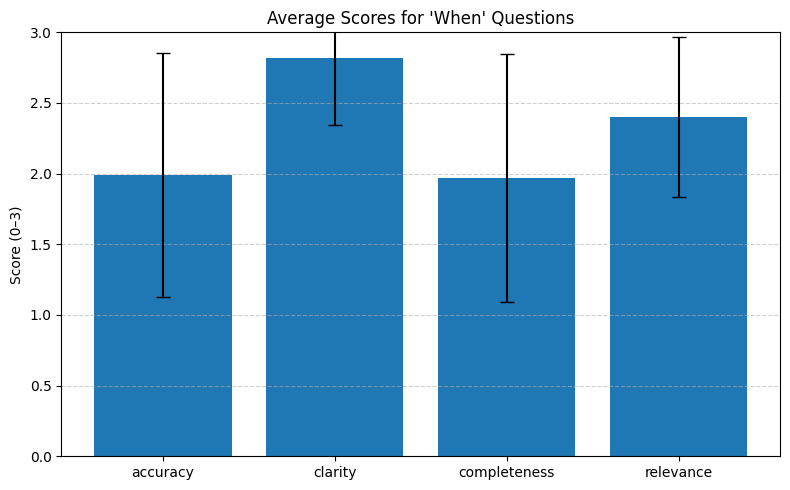

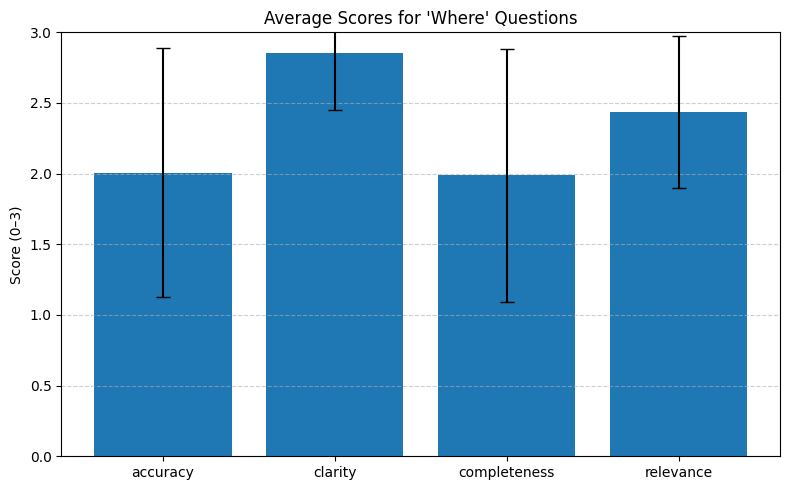

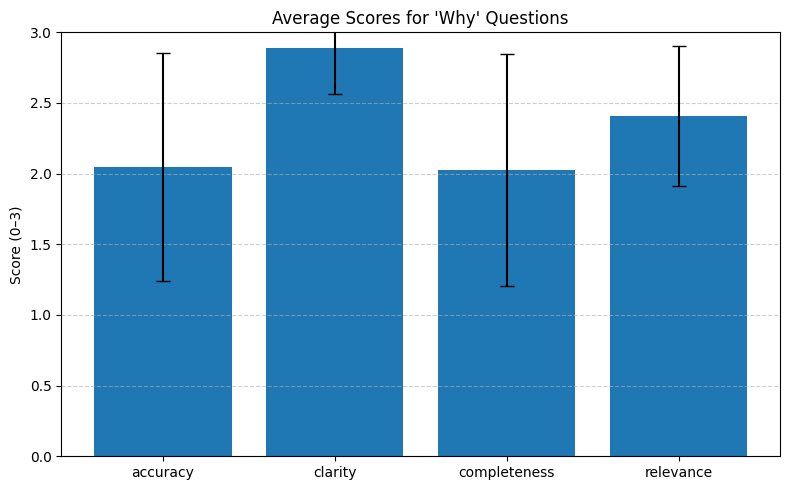

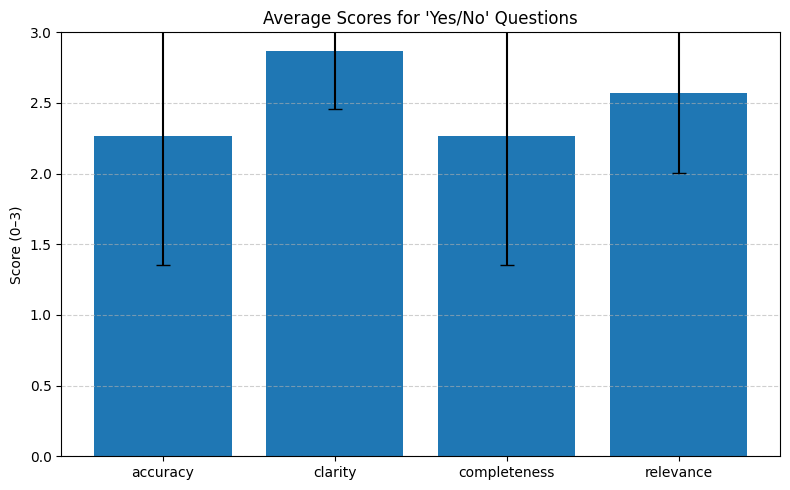

      Question Type     Accuracy Completeness      Clarity    Relevance
0  For what purpose  2.20 (0.78)  2.17 (0.81)  2.86 (0.38)  2.58 (0.52)
1               How  2.01 (0.83)  1.98 (0.85)  2.80 (0.48)  2.44 (0.56)
2             Other  1.60 (0.80)  1.60 (0.80)  2.75 (0.59)  2.20 (0.56)
3              What  2.01 (0.81)  1.98 (0.82)  2.83 (0.41)  2.45 (0.52)
4              When  1.99 (0.86)  1.97 (0.88)  2.82 (0.47)  2.40 (0.57)
5             Where  2.01 (0.88)  1.99 (0.89)  2.86 (0.41)  2.44 (0.54)
6               Why  2.05 (0.81)  2.02 (0.82)  2.89 (0.32)  2.41 (0.50)
7            Yes/No  2.27 (0.92)  2.27 (0.92)  2.87 (0.42)  2.57 (0.57)


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

path = "CodeQA_Part1.csv"

# === Step 1: Load dataset (works for JSON list OR CSV) ===
def load_dataset(path):
    # Try JSON first
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if isinstance(data, list):
            return pd.DataFrame(data)
    except Exception:
        pass

    # Fallback: CSV
    return pd.read_csv(path)

df = load_dataset(path)

# === Step 2: Classify question types (Wh- / Yes-No) ===
def classify_question_type(q):
    q = "" if pd.isna(q) else str(q).strip()
    q_lower = q.lower()

    # Handle leading punctuation/quotes/spaces
    q_lower = q_lower.lstrip('"\''"“”‘’()[]{} \t\n\r")

    if q_lower.startswith("for what purpose"):
        return "For what purpose"
    if q_lower.startswith("what"):
        return "What"
    if q_lower.startswith("how"):
        return "How"
    if q_lower.startswith("where"):
        return "Where"
    if q_lower.startswith("when"):
        return "When"
    if q_lower.startswith("why"):
        return "Why"
    if q_lower.startswith(("does", "do", "is", "are", "can", "should", "could", "would", "will", "did", "was", "were")):
        return "Yes/No"
    return "Other"

df["question_type"] = df["question"].apply(classify_question_type)

# === Step 3: Extract/normalize metric scores ===
metrics = ["accuracy", "clarity", "completeness", "relevance"]

def extract_score(x):
    # dict case: {"score": ...}
    if isinstance(x, dict):
        return x.get("score")
    # stringified dict case: '{"score": 2, ...}'
    if isinstance(x, str) and x.strip().startswith("{") and "score" in x:
        try:
            return json.loads(x).get("score")
        except Exception:
            return pd.NA
    # numeric case
    if isinstance(x, (int, float)):
        return x
    return pd.NA

for m in metrics:
    if m in df.columns:
        df[m] = df[m].apply(extract_score)
        df[m] = pd.to_numeric(df[m], errors="coerce")

# === Step 4: Plot mean ± std for each question type ===
def visualize_scores(subset, title):
    stats = subset[metrics].agg(["mean", "std"]).T.fillna(0)

    plt.figure(figsize=(8, 5))
    plt.bar(stats.index, stats["mean"], yerr=stats["std"], capsize=5)
    plt.title(title)
    plt.ylabel("Score (0–3)")
    plt.ylim(0, 3)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

for qtype, subset in df.groupby("question_type"):
    if subset[metrics].notna().any().any():
        visualize_scores(subset, f"Average Scores for '{qtype}' Questions")

# === Step 5: Summary table ===
summary_rows = []
for qtype, subset in df.groupby("question_type"):
    row = {"Question Type": qtype}
    for m in metrics:
        mean_val = subset[m].mean()
        std_val = subset[m].std()
        if pd.notna(mean_val):
            row[m.capitalize()] = f"{mean_val:.2f} ({(0 if pd.isna(std_val) else std_val):.2f})"
        else:
            row[m.capitalize()] = "N/A"
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df[["Question Type", "Accuracy", "Completeness", "Clarity", "Relevance"]]

print(summary_df)
